In [1]:
import os
import re
import sys
import json
import fnmatch
import spotipy
import pandas as pd
import sqlite3
from sqlite3 import Error
from tqdm import tqdm
from zipfile import ZipFile
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

In [10]:
cwd = os.getcwd()
sys.path.insert(1, os.path.join(cwd, '..'))
import config
# Spotify credentials
os.environ["SPOTIPY_CLIENT_ID"] = config.SPOTIPY_CLIENT_ID
os.environ["SPOTIPY_CLIENT_SECRET"] = config.SPOTIPY_CLIENT_SECRET
os.environ['SPOTIPY_REDIRECT_URI'] = config.SPOTIPY_REDIRECT_URI

In [ ]:
def loop_slices(path, num_slices=20):
    cnt = 0
    mpd_playlists = []
    filenames = os.listdir(path)

    for fname in sorted(filenames):
        print(fname)
        if fname.startswith("mpd.slice.") and fname.endswith(".json"):
            cnt += 1
            fullpath = os.sep.join((path, fname))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)

            # Create a list of all playlists
            for playlist in current_slice['playlists']:
                mpd_playlists.append(playlist)

            if cnt == num_slices:
                break
    return mpd_playlists

# Path where the json files are extracted
path = 'data/'
playlists = loop_slices(path, num_slices=20)

In [ ]:
sp = spotipy.Spotify(client_credentials_manager = SpotifyClientCredentials())

cols_to_keep = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

dfs = []
for playlist in tqdm(playlists):
   audio_feats = []
   for track in playlist['tracks']:
      track_uri = track['track_uri'].split(":")[2]
      feature = sp.audio_features(track_uri)
      if feature:
         audio_feats.append(feature[0])
   avg_feats = pd.DataFrame(audio_feats)[cols_to_keep].mean()
   avg_feats['name'] = playlist['name']
   avg_feats['pid'] = playlist['pid']
   dfs.append(avg_feats.T)

In [ ]:
def loop_slices_zip(zip_file, num_slices=20):
    #print("Number of processors: ", mp.cpu_count())
    with ZipFile(zip_file) as zipfiles:
        file_list = zipfiles.namelist()

        #get only the csv files
        json_files = fnmatch.filter(file_list, "*.json")
        json_files_ex = fnmatch.filter(file_list, "*MACOSX*")
        json_files = set(json_files) - set(json_files_ex)
        json_files = [f for i,f in sorted([(int(fn.split('.')[2].split('-')[0]), fn) for fn in json_files])]
        print(json_files[:5])

        cnt = 0
        mpd_playlists = []
        for filename in tqdm(json_files):
            cnt+=1
            with zipfiles.open(filename) as json_file:
                current_slice = json.loads(json_file.read())
                
                # Create a list of all playlists
                for playlist in current_slice['playlists']:
                    mpd_playlists.append(playlist)

                if cnt == num_slices:
                    break
        return mpd_playlists

In [ ]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

cols_to_keep = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
dfs = []

for playlist in tqdm(playlists):
    audio_feats = []
    all_uris_in_plylst = []
    for track in playlist['tracks']:
        uri = track['track_uri'].split("k:")[1]
        all_uris_in_plylst.append(uri)
    #print('pid : ', playlist['pid'])

    chunks_uris = [all_uris_in_plylst[i:i + 100] for i in range(0, len(all_uris_in_plylst), 100)]
    for chunk in  chunks_uris:
        for attempt in range(10):
            try:
                chunk_audio_feats = sp.audio_features(chunk)
                audio_feats.append(chunk_audio_feats)
            except Exception as e: 
                print(e)
                print('playlist: {}, chunk: {}'.format(playlist['name'], chunk))
            else:
                break
        else:
            print('Everything failed')
    
    playlist_audio_feats = [item for sublist in audio_feats for item in sublist]
    name = playlist['name']
    pid = playlist['pid']
    s1 = pd.Series([name, pid], index=['name', 'pid'])
    try: # Try/Except for when there is a None in playlist
        s2 = pd.DataFrame(playlist_audio_feats)[cols_to_keep].mean()
    except:
        print('Playlist "{}" has a None. PID: {}'.format(name, pid))
        s2 = pd.DataFrame([i for i in playlist_audio_feats if i])[cols_to_keep].mean() # List comprehension to remove None from list

    dfs.append(pd.DataFrame(s1.append(s2)).T)

In [ ]:
def write_log(text):
    with open(log_file, 'a') as lf:
        lf.write(str(text) + '\n')

def get_playlist(conn, pid):
    """
    Query playlists by pid
    :param conn: the Connection object
    :param pid:
    :return: playlist
    """
    cur = conn.cursor()
    cur.execute("SELECT * FROM playlists WHERE pid=?", (pid,))
    rows = cur.fetchall()
    playlist = None
    if len(rows) > 0:
        playlist = rows[0]        
    return playlist

def select_track_by_trackuri(conn, track_uri):
    """
    Query tracks by track_uri
    :param conn: the Connection object
    :param track_uri:
    :return: track_id
    """
    cur = conn.cursor()
    cur.execute("SELECT track_id FROM tracks WHERE track_uri=?", (track_uri,))
    rows = cur.fetchall()
    track_id = 0
    if len(rows) > 0:
        track_id = rows[0][0]        
    return track_id

# This function takes somuch time because of loops, so didn't use it
def process_json_data_loop(conn, zip_file, filename, num_playlists, max_track_id):
    print('File: ' + filename)
    write_log('File: ' + filename)

    playlists = []
    ratings = []
    tracks = []
    cnt = 0
    with ZipFile(zip_file) as zipfiles:
        with zipfiles.open(filename) as json_file:
            json_data = json.loads(json_file.read())
            for playlist in json_data['playlists']:
                pl = get_playlist(conn, playlist['pid'])
                if pl != None:
                    write_log('Playlist already exists in database: ' + str(playlist['pid']))
                    print('Playlist already exists in database: ' + str(playlist['pid']))
                    # Playlist already exists in table
                    continue
                else:
                    write_log('Processing Playlist pid: ' + str(playlist['pid']))
                    print('Processing Playlist pid: ' + str(playlist['pid']))
                cnt += 1
                new_playlist = [playlist['pid'], playlist['name'], playlist['num_albums'], playlist['num_artists'], playlist['num_edits'], 
                                playlist['num_tracks'], playlist['collaborative'], playlist['duration_ms'], playlist['modified_at']]
                playlists.append(new_playlist)

                for track in playlist['tracks']:
                    track_uri = track['track_uri'].split(':')[2]
                    write_log('Processing Track: ' + track_uri)
                    # Check if track_uri exists in the tracks list
                    track_id = next((t[0] for t in tracks if track_uri in t), None)
                    if not track_id:
                        write_log('Track not found in tracks list: ' + track_uri)
                        # Check track_uri exists in the database
                        track_id = select_track_by_trackuri(conn, track_uri)
                        if track_id == 0:
                            write_log('Track not found in database: ' + track_uri)
                            album_uri = track['album_uri'].split(':')[2]
                            artist_uri = track['artist_uri'].split(':')[2]
                            # (max_track_id + 1) tracks already exist in database
                            track_id = len(tracks) + (max_track_id + 1)
                            new_track = [track_id, track['track_name'], track_uri, track['album_name'], album_uri, track['artist_name'], artist_uri]
                            write_log('Adding Track to database: ' + str(track_id))
                            tracks.append(new_track)
                    
                    new_rating = [playlist['pid'], track_id, track['pos'], playlist['num_followers']]
                    write_log('Adding Rating for pid:' + str(playlist['pid']) + ' track_id: ' + str(track_id))
                    ratings.append(new_rating)

                if (cnt == num_playlists) and (num_playlists > 0):
                    break

            playlist_cols = ['pid','name','num_albums','num_artists','num_edits','num_tracks','collaborative','duration_ms','modified_at']
            playlists_df = pd.DataFrame(playlists, columns=playlist_cols)
            #print(playlists_df.head())
            write_log('Adding all playlists to database from file: ' + filename)
            playlists_df.to_sql(name='playlists', con=conn, if_exists='append', index=False)

            rating_cols = ['pid', 'track_id', 'pos', 'num_followers']
            ratings_df = pd.DataFrame(ratings, columns=rating_cols)
            #print(ratings_df.head())
            write_log('Adding all ratings to database from file: ' + filename)
            ratings_df.to_sql(name='ratings', con=conn, if_exists='append', index=False)

            track_cols = ['track_id', 'track_name', 'track_uri', 'album_name', 'album_uri', 'artist_name', 'artist_uri']
            tracks_df = pd.DataFrame(tracks, columns=track_cols)
            #print(tracks_df.tail())
            write_log('Adding all tracks to database from file: ' + filename)
            tracks_df.to_sql(name='tracks', con=conn, if_exists='append', index=False)

    if conn:
        conn.close()

In [3]:
import plotly.express as px
from plotly.subplots import make_subplots

with open('../data/read_spotify_mpd_complete_log.txt') as log_file:
   playlist_files = []
   total_tracks = []
   exist_tracks = []
   new_tracks = []
   for line in log_file:
      line = line.strip()
      if 'Created new track_ids' in line:
         new_tracks.append(int(line.split(':')[1].rstrip()))
      if 'Tracks already exist' in line:
         exist_tracks.append(int(line.split(':')[1].rstrip()))
      if 'Total tracks/ratings in this file' in line:
         total_tracks.append(int(line.split(':')[1].rstrip()))
      if 'File: data/mpd.slice' in line:
         playlist_files.append(line.split('.')[-2])

   rows = 300
   exist_tracks_df = pd.DataFrame(zip(playlist_files, exist_tracks), columns=['files', 'num of tracks'])
   exist_tracks_df['tracks'] = 'existing'
   new_tracks_df = pd.DataFrame(zip(playlist_files, new_tracks), columns=['files', 'num of tracks'])
   new_tracks_df['tracks'] = 'new'
   total_tracks_df = pd.DataFrame(zip(playlist_files, total_tracks), columns=['files', 'num of tracks'])
   total_tracks_df['tracks'] = 'total'
   tracks_df = pd.concat([exist_tracks_df.iloc[:rows], total_tracks_df.iloc[:rows], new_tracks_df.iloc[:rows]])
   
   #subfig = make_subplots(rows=2, cols=1, specs=[[{"type": "xy"}], [{"type": "xy"}]])
   #subfig.add_bar(row=1, col=1, y=tracks_df['num of tracks'], x=tracks_df['files'])
   #subfig.add_bar(row=2, col=1, y=new_tracks_df['num of tracks'], x=new_tracks_df['files'])
   fig = px.bar(tracks_df[tracks_df['tracks'] != 'existing'],
             x='files',
             y='num of tracks',
             color='tracks',
             barmode='overlay')
   fig.show()
   
   fig = px.bar(tracks_df[tracks_df['tracks'] != 'total'],
             x='files',
             y='num of tracks',
             color='tracks',
             barmode='stack')
   fig.show()


In [20]:
sp = spotipy.Spotify(client_credentials_manager = SpotifyClientCredentials())
#json_data = sp.playlist('37i9dQZF1DX9tzt7g58Xlh')
json_data = sp.playlist_items('37i9dQZF1DX9tzt7g58Xlh', offset=0)
import pprint
print(json_data['total'], len(json_data['items']))
pprint.pprint(json_data['items'])

60 60
[{'added_at': '2021-10-30T06:04:11Z',
  'added_by': {'external_urls': {'spotify': 'https://open.spotify.com/user/'},
               'href': 'https://api.spotify.com/v1/users/',
               'id': '',
               'type': 'user',
               'uri': 'spotify:user:'},
  'is_local': False,
  'primary_color': None,
  'track': {'album': {'album_type': 'single',
                      'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53XhwfbYqKCa1cC15pYq2q'},
                                   'href': 'https://api.spotify.com/v1/artists/53XhwfbYqKCa1cC15pYq2q',
                                   'id': '53XhwfbYqKCa1cC15pYq2q',
                                   'name': 'Imagine Dragons',
                                   'type': 'artist',
                                   'uri': 'spotify:artist:53XhwfbYqKCa1cC15pYq2q'},
                                  {'external_urls': {'spotify': 'https://open.spotify.com/artist/6U3ybJ9UHNKEdsH7ktGBZ7'},
             

In [45]:
# 151 Songs, will get first 100
json_data = sp.playlist('37i9dQZF1DX4pUKG1kS0Ac')
# 60 Songs, got 60
#json_data = sp.playlist('37i9dQZF1DX9tzt7g58Xlh')
print(len(json_data['tracks']['items']), json_data['tracks']['offset'], json_data['tracks']['total'])
print(json_data['tracks']['previous'])
print(json_data['tracks']['next'])
pprint.pprint(json_data)

100 0 151
None
https://api.spotify.com/v1/playlists/37i9dQZF1DX4pUKG1kS0Ac/tracks?offset=100&limit=100&additional_types=track
{'collaborative': False,
 'description': 'Embrace your secret favorites.',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DX4pUKG1kS0Ac'},
 'followers': {'href': None, 'total': 3076693},
 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DX4pUKG1kS0Ac?additional_types=track',
 'id': '37i9dQZF1DX4pUKG1kS0Ac',
 'images': [{'height': None,
             'url': 'https://i.scdn.co/image/ab67706f000000034a2afca194d4819c57201bc3',
             'width': None}],
 'name': 'Guilty Pleasures',
 'owner': {'display_name': 'Spotify',
           'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
           'href': 'https://api.spotify.com/v1/users/spotify',
           'id': 'spotify',
           'type': 'user',
           'uri': 'spotify:user:spotify'},
 'primary_color': '#ffffff',
 'public': True,
 'snapshot_id': 'MTYzOTM0NTY5

In [49]:
results = sp.playlist('37i9dQZF1DX4pUKG1kS0Ac')['tracks']
json_data = results['items']
while results['next']:
   results = sp.next(results)
   json_data.extend(results['items'])

print(len(json_data))

151


In [50]:
#tracks = pd.json_normalize(json_data['items'], record_path=['track', 'artists'], meta=[['track', 'name'], ['track', 'id'], ['track', 'album', 'name'], ['track', 'album', 'id']])
tracks = pd.json_normalize(json_data, record_path=['track', 'artists'], meta=[['added_at'], ['track', 'id'], ['track', 'name']])
print(tracks.head())
tracks.columns

                                                href                      id  \
0  https://api.spotify.com/v1/artists/4AK6F7OLvEQ...  4AK6F7OLvEQ5QYCBNiQWHq   
1  https://api.spotify.com/v1/artists/5YGY8feqx7n...  5YGY8feqx7naU7z4HrwZM6   
2  https://api.spotify.com/v1/artists/6DIS6PRrLS3...  6DIS6PRrLS3wbnZsf7vYic   
3  https://api.spotify.com/v1/artists/19ra5tSw0tW...  19ra5tSw0tWufvUp8GotLo   
4  https://api.spotify.com/v1/artists/06HL4z0CvFA...  06HL4z0CvFAxyc27GXpf02   

             name    type                                    uri  \
0   One Direction  artist  spotify:artist:4AK6F7OLvEQ5QYCBNiQWHq   
1     Miley Cyrus  artist  spotify:artist:5YGY8feqx7naU7z4HrwZM6   
2   WALK THE MOON  artist  spotify:artist:6DIS6PRrLS3wbnZsf7vYic   
3  George Michael  artist  spotify:artist:19ra5tSw0tWufvUp8GotLo   
4    Taylor Swift  artist  spotify:artist:06HL4z0CvFAxyc27GXpf02   

                               external_urls.spotify              added_at  \
0  https://open.spotify.com/arti

Index(['href', 'id', 'name', 'type', 'uri', 'external_urls.spotify',
       'added_at', 'track.id', 'track.name'],
      dtype='object')

In [42]:
tracks = pd.json_normalize(json_data['items'])
print(len(tracks))
tracks.head()

100


,added_at,is_local,primary_color,added_by.external_urls.spotify,added_by.href,added_by.id,added_by.type,added_by.uri,track.album.album_type,track.album.artists,...,track.id,track.is_local,track.name,track.popularity,track.preview_url,track.track,track.track_number,track.type,track.uri,video_thumbnail.url
0,2021-11-13T05:06:07Z,False,None,https://open.spotify.com/user/,https://api.spotify.com/v1/users/,,user,spotify:user:,album,[{'external_urls': {'spotify': 'https://open.s...,...,4cluDES4hQEUhmXj6TXkSo,False,What Makes You Beautiful,84,https://p.scdn.co/mp3-preview/170a9a5c3c9d418b...,True,1,track,spotify:track:4cluDES4hQEUhmXj6TXkSo,None
1,2021-11-13T05:06:07Z,False,None,https://open.spotify.com/user/,https://api.spotify.com/v1/users/,,user,spotify:user:,album,[{'external_urls': {'spotify': 'https://open.s...,...,5Q0Nhxo0l2bP3pNjpGJwV1,False,Party In The U.S.A.,75,None,True,2,track,spotify:track:5Q0Nhxo0l2bP3pNjpGJwV1,None
2,2021-11-13T05:06:07Z,False,None,https://open.spotify.com/user/,https://api.spotify.com/v1/users/,,user,spotify:user:,album,[{'external_urls': {'spotify': 'https://open.s...,...,4kbj5MwxO1bq9wjT5g9HaA,False,Shut Up and Dance,83,https://p.scdn.co/mp3-preview/50171ad2206e8f6b...,True,3,track,spotify:track:4kbj5MwxO1bq9wjT5g9HaA,None
3,2021-11-13T05:06:07Z,False,None,https://open.spotify.com/user/,https://api.spotify.com/v1/users/,,user,spotify:user:,compilation,[{'external_urls': {'spotify': 'https://open.s...,...,4jDmJ51x1o9NZB5Nxxc7gY,False,Careless Whisper,85,https://p.scdn.co/mp3-preview/75d3d091213d60d9...,True,3,track,spotify:track:4jDmJ51x1o9NZB5Nxxc7gY,None
4,2021-11-13T05:06:07Z,False,None,https://open.spotify.com/user/,https://api.spotify.com/v1/users/,,user,spotify:user:,album,[{'external_urls': {'spotify': 'https://open.s...,...,1vrd6UOGamcKNGnSHJQlSt,False,Love Story,71,None,True,3,track,spotify:track:1vrd6UOGamcKNGnSHJQlSt,None


In [3]:
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
tracks = sp.current_user_saved_tracks()

In [4]:
tracks['items']

[{'added_at': '2021-09-05T22:32:25Z',
  'track': {'album': {'album_type': 'album',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/53XhwfbYqKCa1cC15pYq2q'},
      'href': 'https://api.spotify.com/v1/artists/53XhwfbYqKCa1cC15pYq2q',
      'id': '53XhwfbYqKCa1cC15pYq2q',
      'name': 'Imagine Dragons',
      'type': 'artist',
      'uri': 'spotify:artist:53XhwfbYqKCa1cC15pYq2q'}],
    'available_markets': ['AD',
     'AE',
     'AG',
     'AL',
     'AM',
     'AO',
     'AR',
     'AT',
     'AU',
     'AZ',
     'BA',
     'BB',
     'BD',
     'BE',
     'BF',
     'BG',
     'BH',
     'BI',
     'BJ',
     'BO',
     'BR',
     'BS',
     'BT',
     'BW',
     'BY',
     'BZ',
     'CA',
     'CD',
     'CG',
     'CH',
     'CI',
     'CL',
     'CM',
     'CO',
     'CR',
     'CV',
     'CW',
     'CY',
     'CZ',
     'DE',
     'DJ',
     'DK',
     'DM',
     'DO',
     'DZ',
     'EC',
     'EE',
     'EG',
     'ES',
     'FI',
     'FJ',
    

In [48]:
tracks_df = pd.json_normalize(tracks['items'], record_path=['track', 'artists'], meta=[['added_at'], ['track', 'uri'], ['track', 'name']])
tracks_df = tracks_df.drop_duplicates(subset='track.uri', keep="first")
#[['added_at', 'track.uri','track.name']]
tracks_df['added_at'] = pd.to_datetime(tracks_df['added_at'])
tracks_df = tracks_df.sort_values(by='added_at', ascending=True).set_index('added_at')
tracks_df = tracks_df.last('3M')[['name', 'uri', 'track.uri', 'track.name']]
tracks_df.rename(columns={'track.uri':'uri', 'track.name': 'song', 'name': 'artist', 'uri': 'artist_uri'}, inplace=True)
tracks_df

,artist,artist_uri,uri,song
added_at,,,,
2021-07-27 01:09:07+00:00,Mithoon,spotify:artist:09UmIX92EUH9hAK4bxvHx6,spotify:track:7rMqbvNImA6wy8lxlNUMmj,"Bolo Har Har Har (feat. Mohit Chauhan, Sukhwin..."
2021-08-20 00:51:53+00:00,Karthik,spotify:artist:0LSPREIgGMZXCuKVel7LVD,spotify:track:2OTWTkshnDUT3pKrf0ElOh,Nuvvani Idhi Needani
2021-08-27 20:55:52+00:00,Karunya,spotify:artist:6qrS6jqZfr8HJe3IWkQqv2,spotify:track:59j1ZUoWtcJqiEycTmOl0d,Ola Olaala Ala
2021-09-05 22:32:25+00:00,Imagine Dragons,spotify:artist:53XhwfbYqKCa1cC15pYq2q,spotify:track:1lgN0A2Vki2FTON5PYq42m,Warriors


In [62]:
tracks_df.iloc[2]['uri'] = 'fjdkk'
tracks_df

,artist,artist_uri,uri,song
added_at,,,,
2021-07-27 01:09:07+00:00,Mithoon,spotify:artist:09UmIX92EUH9hAK4bxvHx6,spotify:track:7rMqbvNImA6wy8lxlNUMmj,"Bolo Har Har Har (feat. Mohit Chauhan, Sukhwin..."
2021-08-20 00:51:53+00:00,Karthik,spotify:artist:0LSPREIgGMZXCuKVel7LVD,spotify:track:2OTWTkshnDUT3pKrf0ElOh,Nuvvani Idhi Needani
2021-08-27 20:55:52+00:00,Karunya,spotify:artist:6qrS6jqZfr8HJe3IWkQqv2,fjdkk,Ola Olaala Ala
2021-09-05 22:32:25+00:00,Imagine Dragons,spotify:artist:53XhwfbYqKCa1cC15pYq2q,spotify:track:1lgN0A2Vki2FTON5PYq42m,Warriors


In [50]:
audio_feats = []
all_uris = tracks_df['uri'].tolist()
chunks_uris = [all_uris[i:i + 100] for i in range(0, len(all_uris), 100)]
for chunk in  chunks_uris:
   for attempt in range(10):
         try:
            chunk_audio_feats = sp.audio_features(chunk)
            audio_feats.append(chunk_audio_feats)
         except Exception as e: 
            print(e)
            print('chunk: {}'.format(chunk))
         else:
            break
   else:
         print('Everything failed')

all_audio_feats = [item for sublist in audio_feats for item in sublist if item]

In [51]:
audio_feats_df = pd.DataFrame(all_audio_feats)
audio_feats_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.598,0.813,9,-6.107,1,0.0660,0.2780,0.000000,0.1090,0.311,140.101,audio_features,7rMqbvNImA6wy8lxlNUMmj,spotify:track:7rMqbvNImA6wy8lxlNUMmj,https://api.spotify.com/v1/tracks/7rMqbvNImA6w...,https://api.spotify.com/v1/audio-analysis/7rMq...,294331,4
1,0.688,0.765,9,-4.883,0,0.0624,0.6490,0.000014,0.0712,0.410,100.016,audio_features,2OTWTkshnDUT3pKrf0ElOh,spotify:track:2OTWTkshnDUT3pKrf0ElOh,https://api.spotify.com/v1/tracks/2OTWTkshnDUT...,https://api.spotify.com/v1/audio-analysis/2OTW...,260700,4
2,0.365,0.851,4,-6.238,0,0.0650,0.0964,0.003000,0.2380,0.309,78.068,audio_features,1lgN0A2Vki2FTON5PYq42m,spotify:track:1lgN0A2Vki2FTON5PYq42m,https://api.spotify.com/v1/tracks/1lgN0A2Vki2F...,https://api.spotify.com/v1/audio-analysis/1lgN...,170067,4


In [52]:
fav_songs_feats_df = tracks_df.merge(audio_feats_df, how='right', on="uri")
fav_songs_feats_df

,artist,artist_uri,uri,song,danceability,energy,key,loudness,mode,speechiness,...,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Mithoon,spotify:artist:09UmIX92EUH9hAK4bxvHx6,spotify:track:7rMqbvNImA6wy8lxlNUMmj,"Bolo Har Har Har (feat. Mohit Chauhan, Sukhwin...",0.598,0.813,9,-6.107,1,0.0660,...,0.000000,0.1090,0.311,140.101,audio_features,7rMqbvNImA6wy8lxlNUMmj,https://api.spotify.com/v1/tracks/7rMqbvNImA6w...,https://api.spotify.com/v1/audio-analysis/7rMq...,294331,4
1,Karthik,spotify:artist:0LSPREIgGMZXCuKVel7LVD,spotify:track:2OTWTkshnDUT3pKrf0ElOh,Nuvvani Idhi Needani,0.688,0.765,9,-4.883,0,0.0624,...,0.000014,0.0712,0.410,100.016,audio_features,2OTWTkshnDUT3pKrf0ElOh,https://api.spotify.com/v1/tracks/2OTWTkshnDUT...,https://api.spotify.com/v1/audio-analysis/2OTW...,260700,4
2,Imagine Dragons,spotify:artist:53XhwfbYqKCa1cC15pYq2q,spotify:track:1lgN0A2Vki2FTON5PYq42m,Warriors,0.365,0.851,4,-6.238,0,0.0650,...,0.003000,0.2380,0.309,78.068,audio_features,1lgN0A2Vki2FTON5PYq42m,https://api.spotify.com/v1/tracks/1lgN0A2Vki2F...,https://api.spotify.com/v1/audio-analysis/1lgN...,170067,4


In [2]:
import numpy as np
import pandas as pd
train_scaled_data = np.loadtxt('../data/scaled_data.csv', delimiter=',')
train_data_scaled_feats_df = pd.DataFrame(train_scaled_data)
train_data_scaled_feats_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.612856,1.087184,-0.201775,0.996660,0.208011,0.192259,-0.913576,-0.473002,-0.007089,1.210086,-0.020760,-0.385630,0.590494
1,-1.181611,0.440106,-1.061919,-0.305130,-0.779607,-0.032644,-0.456511,1.291821,-0.187318,-0.100881,0.497542,1.926104,-1.768360
2,0.685865,0.417537,-0.259118,1.002980,-0.926207,0.063337,0.165333,-0.473291,-0.430553,0.596989,-0.908796,-0.457733,0.590494
3,-0.952022,-0.129984,-0.105293,-0.916527,0.349099,-0.458178,0.191017,1.129130,0.020639,-0.301443,0.570073,-0.151709,0.103746
4,-0.305220,0.094313,-2.714744,-0.113532,1.050391,-0.915264,-0.369455,0.168603,-0.485723,0.006686,0.868141,0.611446,-0.010782


In [6]:
import json
playlists = json.load(open('../data/playlists.json', "r"))
print(playlists[0]['tracks'][0])

{'pos': 0, 'artist_name': 'Missy Elliott', 'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI', 'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk', 'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)', 'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K', 'duration_ms': 226863, 'album_name': 'The Cookbook'}


<AxesSubplot:>

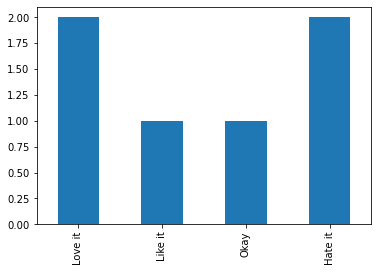

In [15]:
df = pd.DataFrame([['p', 'Love it'], ['p', 'Like it'], ['p', 'Hate it'], ['p', 'Okay'], ['f', 'Love it'], ['f', 'Hate it']],
                  columns=['rec_type', 'feedback'])

vc_df = df['feedback'].value_counts()
fb_order = {'Love it': 0, 'Like it': 1, 'Okay': 2, 'Hate it': 3}
vc_df = vc_df.sort_index(key=lambda x: x.map(fb_order))


vc_df.plot(kind='bar')

In [28]:
import plotly.express as px
vc_df = df[['feedback', 'rec_type']].value_counts().reset_index().rename(columns={0: 'count'})
fb_order = {'Love it': 0, 'Like it': 1, 'Okay': 2, 'Hate it': 3}
vc_df = vc_df.sort_values(by='feedback', key=lambda x: x.map(fb_order))
fig = px.bar(vc_df,
             y='count',
             x='feedback',
             color='rec_type',
             barmode='group')
fig.show()